In [20]:
import os
import sys

import numpy as np
from scipy import stats

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table
from astropy.io import fits

In [ ]:
%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

# Load Data

In [11]:
meanstack_fns = {'draco': ('draco_mean_db_jegpeek.fits.gz', 'stack_draco_jegpeek.fits.gz')}

In [43]:
meanstack_tabs = {}
for nm, (mean_fn, stack_fn) in meanstack_fns.items():
    mean_tab = Table.read(mean_fn)
    stack_tab = Table.read(stack_fn)
    meanstack_tabs[nm] = (mean_tab, stack_tab)

In [48]:
next(iter(meanstack_tabs.values()))[0]

o_nDetections,o_raMean,o_decMean,m_gMeanApMagErr,m_iMeanKronMagErr,m_rMeanApMag,m_zMeanKronMag,m_rMeanApMagErr,m_zMeanKronMagErr,m_gMeanPSFMag,m_iMeanApMag,m_yMeanKronMag,m_gMeanPSFMagErr,m_iMeanApMagErr,m_yMeanKronMagErr,m_rMeanPSFMag,m_zMeanApMag,m_rMeanPSFMagErr,m_zMeanApMagErr,m_iMeanPSFMag,m_yMeanApMag,m_iMeanPSFMagErr,m_yMeanApMagErr,m_gMeanKronMag,m_zMeanPSFMag,m_gMeanKronMagErr,m_zMeanPSFMagErr,m_rMeanKronMag,m_yMeanPSFMag,m_rMeanKronMagErr,m_yMeanPSFMagErr,m_gMeanApMag,m_iMeanKronMag
int16,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32
1,259.0559176,57.41566553,0.31653,-999.0,-999.0,-999.0,-999.0,-999.0,22.1729,-999.0,-999.0,0.31653,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,22.2564,-999.0
1,259.1880543,57.41912636,-999.0,-999.0,-999.0,18.3729,-999.0,0.04886,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,18.2163,-999.0,0.024999,-999.0,-999.0,-999.0,-999.0,-999.0,17.9725,-999.0,0.024999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,259.19006746,57.41931863,-999.0,-999.0,-999.0,17.7582,-999.0,0.042779,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,17.715,-999.0,0.022879,-999.0,-999.0,-999.0,-999.0,-999.0,17.8657,-999.0,0.022879,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
0,259.19047641,57.41699938,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,259.19101419,57.42112874,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,21.1113,-999.0,0.417797,-999.0,-999.0
1,259.19120521,57.42276479,0.19161,-999.0,-999.0,-999.0,-999.0,-999.0,21.9958,-999.0,-999.0,0.19161,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,22.9747,-999.0
1,259.19123998,57.41744054,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,16.7785,-999.0,-999.0,0.018919,-999.0,-999.0,-999.0,-999.0,-999.0,16.67,-999.0,0.010186,-999.0,-999.0,-999.0,-999.0,-999.0,16.3275,-999.0,0.010186,-999.0,-999.0
1,259.19363074,57.41962882,-999.0,-999.0,-999.0,17.3036,-999.0,0.020172,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,17.6957,-999.0,0.010116,-999.0,-999.0,-999.0,-999.0,-999.0,16.8285,-999.0,0.010116,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,259.19458297,57.41981379,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,17.4912,-999.0,0.0089,-999.0,-999.0,-999.0,-999.0,-999.0,16.6297,-999.0,0.0089,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [49]:
next(iter(meanstack_tabs.values()))[1]

st_raStack,st_decStack,st_gPSFMag,st_rPSFMag,st_iPSFMag,st_zPSFMag,st_yPSFMag,st_gPSFMagErr,st_rPSFMagErr,st_iPSFMagErr,st_zPSFMagErr,st_yPSFMagErr,st_gApMag,st_rApMag,st_iApMag,st_zApMag,st_yApMag,st_gApMagErr,st_rApMagErr,st_iApMagErr,st_zApMagErr,st_yApMagErr,st_gKronMag,st_rKronMag,st_iKronMag,st_zKronMag,st_yKronMag,st_gKronMagErr,st_rKronMagErr,st_iKronMagErr,st_zKronMagErr,st_yKronMagErr
float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
260.0033729,57.4275286,21.5865,20.2532,19.4242,19.1342,18.6692,0.042282,0.013842,0.006821,0.015663,0.020224,21.622,20.2782,19.4327,19.0694,18.6553,0.009353,0.004113,0.001957,0.002784,0.002139,21.7861,20.3854,19.5352,19.1681,18.8004,0.067161,0.020355,0.01148,0.024776,0.033934
260.01647512,57.42470151,16.6737,15.8944,-999.0,15.786,-999.0,0.006143,0.013045,-999.0,0.005005,0.185692,16.1989,16.6332,-999.0,14.9063,15.8719,0.00077,0.000768,-999.0,0.000409,0.000594,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.01647512,57.42470151,16.6737,15.8944,-999.0,15.786,-999.0,0.006143,0.013045,-999.0,0.005005,0.185692,16.1989,16.6332,-999.0,14.9063,15.8719,0.00077,0.000768,-999.0,0.000409,0.000594,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.01647512,57.42470151,-999.0,-999.0,15.1588,-999.0,18.5772,-999.0,-999.0,0.001573,-999.0,0.074033,-999.0,-999.0,15.9183,-999.0,15.9618,-999.0,-999.0,0.000388,-999.0,0.000619,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.01647512,57.42470151,-999.0,-999.0,15.1588,-999.0,18.5772,-999.0,-999.0,0.001573,-999.0,0.074033,-999.0,-999.0,15.9183,-999.0,15.9618,-999.0,-999.0,0.000388,-999.0,0.000619,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.02275962,57.43262296,-999.0,-999.0,-999.0,25.8609,21.2717,0.486614,0.413184,2.3412,5.44683,0.198775,-999.0,-999.0,-999.0,25.3049,21.2487,0.025094,0.016984,0.015228,0.049182,0.00706,-999.0,-999.0,-999.0,-999.0,21.002,-999.0,-999.0,-999.0,-999.0,0.288497
260.04166095,57.42984656,-999.0,25.1893,22.9765,26.8419,22.0758,1.6881,1.20742,0.163842,12.8607,0.459186,24.2684,-999.0,23.525,-999.0,22.6381,0.03164,0.025884,0.012883,0.021841,0.013387,-999.0,-999.0,23.3208,-999.0,-999.0,-999.0,-999.0,0.299629,-999.0,-999.0
260.05339703,57.42819067,22.7774,21.6236,20.956,20.6425,20.2708,0.097722,0.045791,0.025751,0.043203,0.081305,22.041,21.1735,20.3401,20.0239,19.5465,0.011344,0.006211,0.002972,0.004321,0.003224,22.0597,21.0261,20.2658,20.0392,19.4981,0.106365,0.052522,0.027109,0.047862,0.081551
260.0723225,57.42908103,23.4046,25.2127,-999.0,-999.0,22.1166,0.180236,1.10416,0.337676,1.1329,0.492831,24.9435,-999.0,-999.0,-999.0,21.648,0.043178,0.01807,0.010564,0.031149,0.008485,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


# Star/Galaxy Separation 

0.31731050786291415

In [129]:
def stargalprob(r_kron, r_kron_err, r_ap, r_ap_err, r_psf, r_psf_err):
    kronpsferr = np.hypot(r_kron_err, r_psf_err)
    appsferr = np.hypot(r_ap_err, r_psf_err)
    
    dkron = np.abs(r_kron-r_psf)/kronpsferr
    dap = np.abs(r_ap-r_psf)/appsferr
    
    dmean = (dkron + dap)/2
    return stats.norm.cdf(-dmean,0,1)*2

In [130]:
for mean_tab, stack_tab in meanstack_tabs.values():
    mean_tab['starprob'] = stargalprob(mean_tab['m_rMeanKronMag'], mean_tab['m_rMeanKronMagErr'],
                                       mean_tab['m_rMeanApMag'], mean_tab['m_rMeanApMagErr'],
                                       mean_tab['m_rMeanPSFMag'], mean_tab['m_rMeanPSFMagErr'])
    stack_tab['starprob'] = stargalprob(stack_tab['st_rKronMag'], stack_tab['st_rKronMagErr'],
                                        stack_tab['st_rApMag'], stack_tab['st_rApMagErr'],
                                        stack_tab['st_rPSFMag'], stack_tab['st_rPSFMagErr'])

# Randomize and show 

In [ ]:
randomized_order = np.random.permutation(list(meanstack_tabs.keys()))

#Paste this in the cell below for final judgements *before* revealing the names:
sat_present = {}
sat_present[0] = 'unknown' # 'yes', 'no', 'maybe'
sat_present


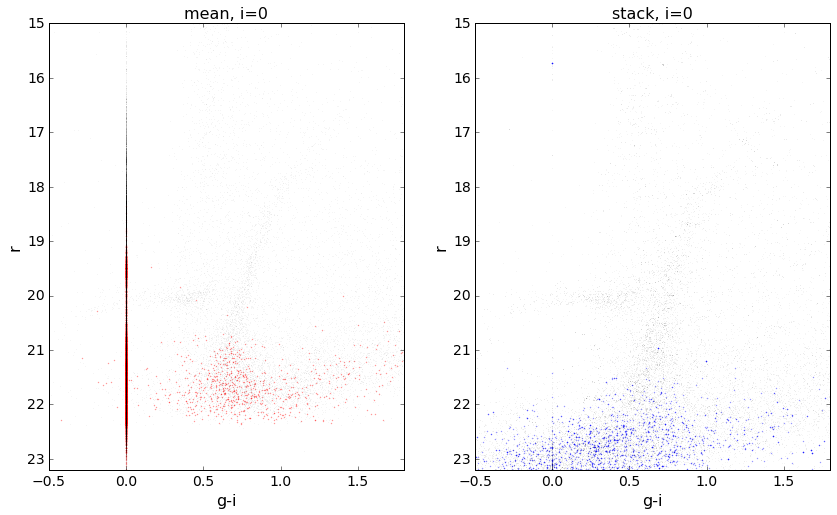

In [133]:
for i, nm in enumerate(randomized_order):
    mean_tab, stack_tab = meanstack_tabs[nm]
    
    plt.figure()
    
    gmi_stack = stack_tab['st_gPSFMag'] - stack_tab['st_iPSFMag']
    r_stack = stack_tab['st_rPSFMag']
    starmsk_stack = stack_tab['starprob'] >0.5

    gmi_mean = mean_tab['m_gMeanPSFMag'] - mean_tab['m_iMeanPSFMag']
    r_mean = mean_tab['m_rMeanPSFMag']
    starmsk_mean = mean_tab['starprob'] >0.5

    fig, axs = plt.subplots(1, 2)
    axs[0].scatter(gmi_mean[starmsk_mean], r_mean[starmsk_mean], alpha=.4, lw=0, s=2, c='r')
    axs[0].scatter(gmi_mean[~starmsk_mean], r_mean[~starmsk_mean], alpha=.05, lw=0, s=1, c='k')
    axs[1].scatter(gmi_stack[starmsk_stack], r_stack[starmsk_stack], alpha=.4, lw=0, s=2, c='b')
    axs[1].scatter(gmi_stack[~starmsk_stack], r_stack[~starmsk_stack], alpha=.05, lw=0, s=1, c='k')

    for ax in axs:
        ax.set_xlim(-.5, 1.8)
        ax.set_ylim(23.2, 15)

        ax.set_xlabel('g-i')
        ax.set_ylabel('r')

    axs[0].set_title('mean, i={}'.format(i))
    axs[1].set_title('stack, i={}'.format(i))
    
    
print('#Paste this in the cell below for final judgements *before* revealing the names:')
print('sat_present = {}')
for i in range(len(randomized_order)):
    print("sat_present[{}] = 'unknown' # 'yes', 'no', 'maybe'".format(i))
print('sat_present')

# Appendices

# S/G separation w/Kron

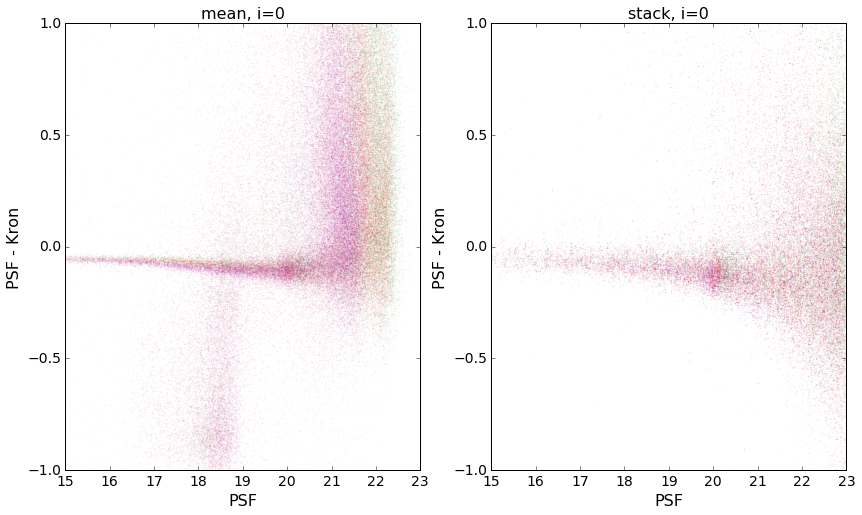

In [103]:
for i, nm in enumerate(randomized_order):
    mean_tab, stack_tab = meanstack_tabs[nm]
    
    fig, axs = plt.subplots(1, 2)
    for band, color in zip('gri', 'grm'):
        other = mean_tab['m_{}MeanKronMag'.format(band)]
        psf = mean_tab['m_{}MeanPSFMag'.format(band)]
        axs[0].scatter(psf, psf-other, alpha=.05, lw=0, s=2, c=color)
        
        other = stack_tab['st_{}KronMag'.format(band)]
        psf = stack_tab['st_{}PSFMag'.format(band)]
        axs[1].scatter(psf, psf-other, alpha=.05, lw=0, s=2, c=color)
    
    axs[0].set_title('mean, i={}'.format(i))
    axs[1].set_title('stack, i={}'.format(i))
    
    for ax in axs:
        ax.set_xlabel('PSF')
        ax.set_ylabel('PSF - Kron')
        ax.set_ylim(-1.0, 1.0)
        ax.set_xlim(15, 23)
    

# S/G separation w/Aperture mag

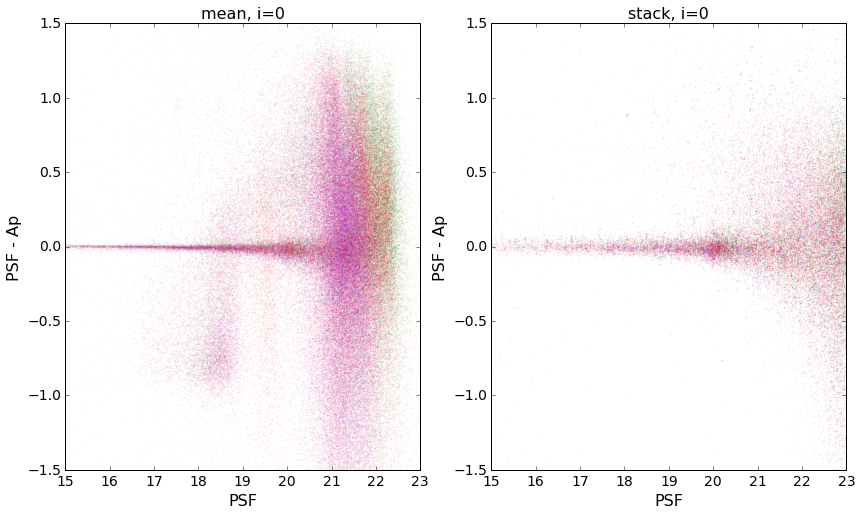

In [104]:
for i, nm in enumerate(randomized_order):
    mean_tab, stack_tab = meanstack_tabs[nm]
    
    fig, axs = plt.subplots(1, 2)
    for band, color in zip('gri', 'grm'):
        other = mean_tab['m_{}MeanApMag'.format(band)]
        psf = mean_tab['m_{}MeanPSFMag'.format(band)]
        axs[0].scatter(psf, psf-other, alpha=.05, lw=0, s=2, c=color)
        
        other = stack_tab['st_{}ApMag'.format(band)]
        psf = stack_tab['st_{}PSFMag'.format(band)]
        axs[1].scatter(psf, psf-other, alpha=.05, lw=0, s=2, c=color)
    
    axs[0].set_title('mean, i={}'.format(i))
    axs[1].set_title('stack, i={}'.format(i))
    
    for ax in axs:
        ax.set_xlabel('PSF')
        ax.set_ylabel('PSF - Ap')
        ax.set_ylim(-1.5, 1.5)
        ax.set_xlim(15, 23)
    

# Uncertainties 

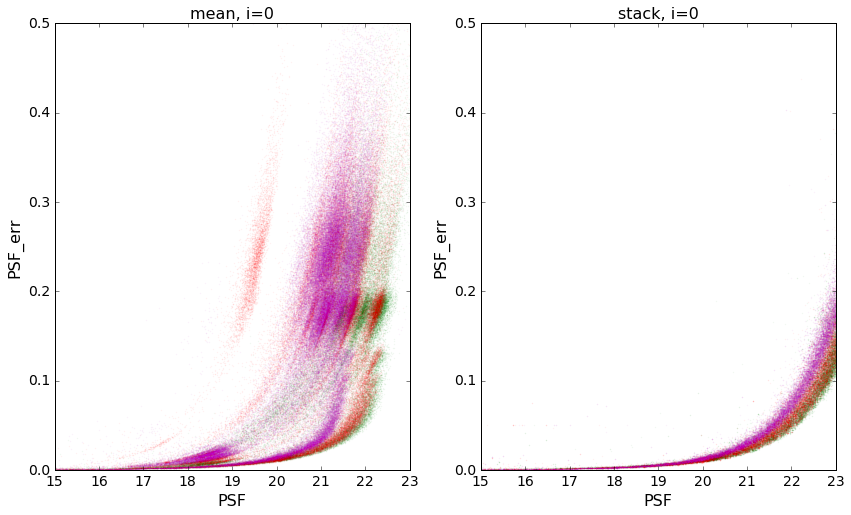

In [96]:
for i, nm in enumerate(randomized_order):
    mean_tab, stack_tab = meanstack_tabs[nm]
    
    fig, axs = plt.subplots(1, 2)
    for band, color in zip('gri', 'grm'):
        psf = mean_tab['m_{}MeanPSFMag'.format(band)]
        psf_err = mean_tab['m_{}MeanPSFMagErr'.format(band)]
        axs[0].scatter(psf, psf_err, alpha=.05, lw=0, s=2, c=color)
        
        psf = stack_tab['st_{}PSFMag'.format(band)]
        psf_err = stack_tab['st_{}PSFMagErr'.format(band)]
        axs[1].scatter(psf, psf_err, alpha=.05, lw=0, s=2, c=color)
    
    axs[0].set_title('mean, i={}'.format(i))
    axs[1].set_title('stack, i={}'.format(i))
    
    for ax in axs:
        ax.set_xlabel('PSF')
        ax.set_ylabel('PSF_err')
        ax.set_ylim(0, .5)
        ax.set_xlim(15, 23)
    

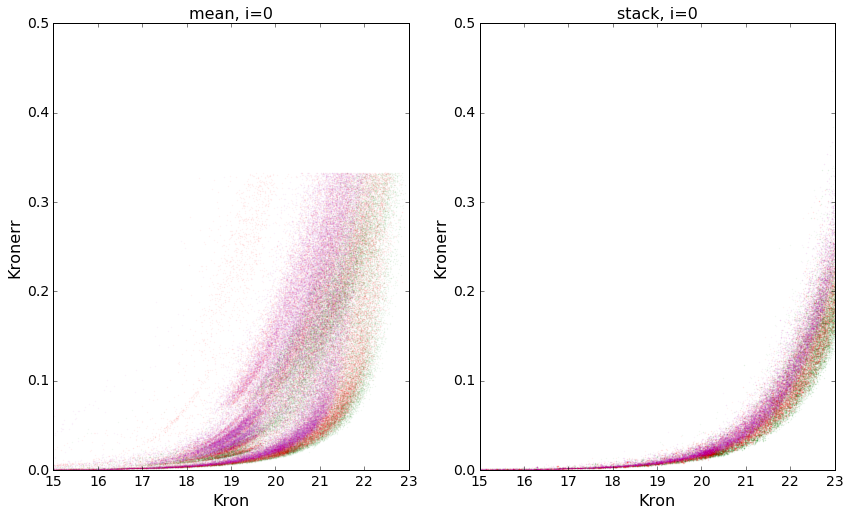

In [97]:
for i, nm in enumerate(randomized_order):
    mean_tab, stack_tab = meanstack_tabs[nm]
    
    fig, axs = plt.subplots(1, 2)
    for band, color in zip('gri', 'grm'):
        psf = mean_tab['m_{}MeanKronMag'.format(band)]
        psf_err = mean_tab['m_{}MeanKronMagErr'.format(band)]
        axs[0].scatter(psf, psf_err, alpha=.05, lw=0, s=2, c=color)
        
        psf = stack_tab['st_{}KronMag'.format(band)]
        psf_err = stack_tab['st_{}KronMagErr'.format(band)]
        axs[1].scatter(psf, psf_err, alpha=.05, lw=0, s=2, c=color)
    
    axs[0].set_title('mean, i={}'.format(i))
    axs[1].set_title('stack, i={}'.format(i))
    
    for ax in axs:
        ax.set_xlabel('Kron')
        ax.set_ylabel('Kron_err')
        ax.set_ylim(0, .5)
        ax.set_xlim(15, 23)
    